In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [33]:
import git
import sys
import os
import time
import cv2
import numpy as np
import pandas as pd
import math
import pdb
import matplotlib.pyplot as plt

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils 
import model.datasets.argoverse.map_functions as map_functions
import model.datasets.argoverse.goal_points_functions as goal_points_functions

from model.datasets.argoverse.map_functions import MapFeaturesUtils
map_features_utils_instance = MapFeaturesUtils()

# Set root_dir to the correct path to your dataset folder

split_name = "test"
split_percentage = 1.0
root_dir = os.path.join(BASE_DIR,
                        f'data/datasets/argoverse/motion-forecasting/{split_name}')
data_processed_dir = os.path.join(root_dir, f'data_processed_{str(int(split_percentage*100))}_percent')

In [34]:
relevant_centerlines_filtered_npz = np.load(os.path.join(data_processed_dir,"relevant_centerlines.npz"),allow_pickle=True)
relevant_centerlines_filtered = relevant_centerlines_filtered_npz['arr_0'].item()

In [31]:
files, num_files = dataset_utils.load_list_from_folder(os.path.join(root_dir,"data"))

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  39472


In [20]:
debug_centerlines = [27353, 57791, 102781, 129915, 143124, 146034, 149913, 154633, 160433, 166298, 168101, 189296, 209572]

debug_indeces = []

for debug_centerline_id in debug_centerlines:
    index = file_id_list.index(debug_centerline_id)
    debug_indeces.append(index)

print("debug_indeces: ", debug_indeces)

debug_indeces:  [26613, 56236, 100007, 126363, 139208, 142045, 145818, 150399, 156057, 161756, 163502, 184151, 203875]


In [29]:
test_centerlines = []
i = j = 0
for file_index in range(len(file_id_list)):
    if file_index in debug_indeces:
        test_centerlines.append(debug_relevant_centerlines[j])
        j += 1
    else:
        test_centerlines.append(unfinished_relevant_centerlines[i])
        i += 1

test_centerlines = np.array(test_centerlines)

filename = root_dir+"data_processed_100_percent/relevant_centerlines.npy"
with open(filename, 'wb') as my_file: np.save(my_file, test_centerlines)

(205942, 40, 2)

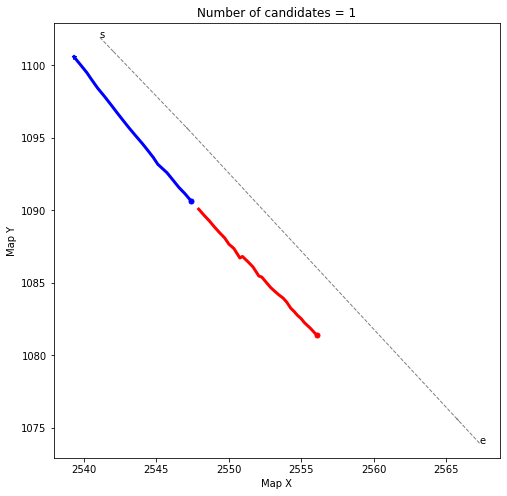

In [32]:
file_id = 160433

obs_len = 20
pred_len = 30

seq_path = os.path.join(root_dir+"data",str(file_id)+".csv")

start = time.time()

# Compute map features using Argoverse Forecasting Baseline algorithm

start = time.time()

df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})

# Get social and map features for the agent

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values
city_name = agent_track[0,RAW_DATA_FORMAT["CITY_NAME"]]
agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
map_features_utils_instance.debug_centerline_and_agent([test_centerlines[file_id_list.index(file_id),:,:]], 
                                                       agent_xy, obs_len, obs_len+pred_len, split_name, file_id)

In [4]:
# Create dummy relevant centerlines (if the file has not not been preprocessed yet. Just to run the dataloader)

split_name = "test"
split_percentage = 1.0
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/')

files, num_files = dataset_utils.load_list_from_folder(root_dir+"data")

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

map_info = dict()

n_files = math.ceil(split_percentage*num_files)
file_id_list_percentage = file_id_list[:n_files]
print("Len file_id_list: ", len(file_id_list_percentage))

start = time.time()
for file_id in file_id_list_percentage:
    seq_map_info = []
    map_info[str(file_id)] = seq_map_info 
end = time.time()
print("Time: ", end-start)
print("Num keys: ", len(map_info.keys()))

folder = os.path.join(root_dir,f"data_processed_{str(int(split_percentage*100))}_percent")
filename = os.path.join(folder,
                        "relevant_centerlines.npz")
with open(filename, 'wb') as my_file: np.savez(my_file, map_info)

Num files:  78143
Len file_id_list:  78143
Time:  0.1435086727142334
Num keys:  78143


In [3]:
def intersect2D(a, b):
  """
  Find row intersection between 2D numpy arrays, a and b.
  Returns another numpy array with shared rows
  """
  return np.array([x for x in set(tuple(x) for x in a) & set(tuple(x) for x in b)])

In [1]:
# Read all plausible areas and store in a single npy array

subfolder = "map_features"
files, num_files = dataset_utils.load_list_from_folder(os.path.join(root_dir,subfolder))

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    if "npy" in file_name or "npz" in file_name:
        pass
    else:
        file_id = int(os.path.normpath(file_name).split('/')[-1].split('_')[0])
        file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

mask = 255
rows = 400 # Default number of rows

save_fig = False
show = True
change_img_bg = False

relevant_centerlines_filtered_npz = np.load(os.path.join(data_processed_dir,"relevant_centerlines.npz"),allow_pickle=True)
relevant_centerlines_filtered = relevant_centerlines_filtered_npz['arr_0'].item()

plausible_area_indeces_list = []

file_id_list = [188893]

for file_id in file_id_list:
    print(">>>>>> File id: ", file_id)
    start_t = time.time()
    relevant_centerlines = relevant_centerlines_filtered[str(file_id)]

    real_world_width = relevant_centerlines["real_world_width"]
    real_world_height = relevant_centerlines["real_world_height"]
    print("RW width, height: ", real_world_width, real_world_height)

    cols = math.ceil(rows*(real_world_width/real_world_height)) 
    scale_x = float(cols/real_world_width) # px/m
    scale_y = float(rows/real_world_height) # px/m
    center_px = (int(rows/2),int(cols/2))
    print("root file name: ", root_file_name)
    filename = os.path.join(root_file_name,f"{file_id}_binary_plausible_area_filtered.png")
    img_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.resize(img_gray, dsize=(cols,rows))

    indeces_white = np.vstack(np.where(img_gray == 255)).T
    # print("Ind white: ", indeces_white.shape)
    # discretized_area_points = 512
    # subsampling = int(math.floor(indeces_white.shape[0] / discretized_area_points))
    # indeces_white_sub = indeces_white[::subsampling]
    # print("Ind white sub: ", indeces_white_sub.shape)
    # fe_x = indeces_white_sub[:,1]
    # fe_y = indeces_white_sub[:,0]
    fe_x = indeces_white[:,1]
    fe_y = indeces_white[:,0]

    # discretized_area_points = 512

    # start = time.time()

    # subsampling_rows = int(rows / 100)
    # subsampling_cols = int(cols / 100)
    # print("Subsampling rows, columns: ", subsampling_rows, subsampling_cols)
    # # print("Subsampling: ", subsampling)

    # total_indeces_rows = np.arange(rows)
    # total_indeces_cols = np.arange(cols)

    # print("pre rows, pre columns: ", rows, cols)

    # fe_x = np.array([])

    # # while(len(fe_x) < discretized_area_points):
    # rows_subsampled = total_indeces_rows[::subsampling_rows]
    # cols_subsampled = total_indeces_cols[::subsampling_cols]
    # print("Rows, cols: ", len(rows_subsampled), len(cols_subsampled))

    # start1 = time.time()
    # index_pair = []
    # for r in rows_subsampled:
    #     for c in cols_subsampled:
    #         pair = np.array([r,c])
    #         index_pair.append(pair)
    # index_pair = np.array(index_pair)
    # end1 = time.time()
    # # print(">> Pairs subsampled: ", end1-start1)

    # start2 = time.time()
    # arr = intersect2D(index_pair,indeces_white)
    # end2 = time.time()
    # # print(">> Intersect time: ", end2-start2)

    # fe_x = arr[:,1]
    # fe_y = arr[:,0]

    # print("Len while: ", len(fe_x))

    # end = time.time()  
    # # print("Time: ", end-start)

    # # sample_index = np.random.randint(low=0,high=len(fe_x),size=discretized_area_points)
    # # sample_index = np.sort(sample_index) # Sort indeces in order to have to pixels sorted (from top-left to bottom right)
    # # fe_x, fe_y = fe_x[sample_index], fe_y[sample_index]

    # if len(fe_x) < discretized_area_points:
    #     subsampling = int(subsampling / 2)

    # fe_x = np.array([])
    # fe_y = np.array([])
    
    img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB) 
    filename2 = os.path.join(root_file_name,f"{file_id}_binary_plausible_area_filtered_discrete.png")
    save_fig = False
    show = True
    goal_points_functions.plot_fepoints(img, filename2, goals_px_x=fe_x, goals_px_y=fe_y,
                                        save_fig=save_fig, show=show, change_bg=change_img_bg)
            # pdb.set_trace()
    if len(fe_x) < discretized_area_points:
        pdb.set_trace()
    plausible_area_indeces = np.vstack((fe_y,fe_x)).T
    plausible_area_indeces_list.append(plausible_area_indeces)

    end_t = time.time()
    
    print("Time: ", end_t-start_t)

# Data aug

# limit = 4
# noise = np.random.randint(-limit,limit,(len(fe_x),2))
# fe_x = fe_x + noise[:,1]
# fe_y = fe_y + noise[:,0]

# fe_x = indeces[1][::subsampling]
# fe_y = indeces[0][::subsampling]

# img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB) 

# goal_points_functions.plot_fepoints(img, filename, goals_px_x=fe_x, goals_px_y=fe_y,
#                                     save_fig=save_fig, show=show, change_bg=change_img_bg)

# # img_list.append(indeces)

# # img_array = np.array(img_list)

# # filename_array = os.path.join(root_file_name,subfolder+".npz")
# # with open(filename_array, 'wb') as my_file: np.savez_compressed(my_file, img_array)

NameError: name 'dataset_utils' is not defined

In [1]:
# N.B. We assume the images were saved with this resolution: 465 (width = cols) x 462 (height = rows) in map_features folder
# We computed the indeces of the plausible area resizing to 400 (rows) x N columns, scaling the number of columns w.r.t. the
# relation between real world width and height

# indeces_plausible_area = np.load(root_dir+"data_processed_1_percent/relevant_centerlines.npz",allow_pickle=True)
root_dir

NameError: name 'root_dir' is not defined

In [5]:
len(relevant_centerlines_filtered)

78143

In [25]:
num_centerlines = []

for file_id in file_id_list:
    # print("file_id: ", file_id)
    num_centerlines_ = len(relevant_centerlines_filtered[str(file_id)]['relevant_centerlines_filtered'])
    # print("num_centerlines: ", num_centerlines_)
    num_centerlines.append(num_centerlines_)

In [35]:
file_id = 1
relevant_centerlines_filtered[str(file_id)]['relevant_centerlines_filtered']

[array([[1538.12667242,  242.81042738],
        [1538.48580104,  242.93540298],
        [1538.27180698,  242.86093373],
        [1537.66936862,  242.65128713],
        [1536.86316433,  242.37073063],
        [1536.03514739,  242.08258339],
        [1535.26834138,  241.81573736],
        [1534.52118738,  241.55573018],
        [1533.75875502,  241.29040622],
        [1532.98724498,  241.02192318],
        [1532.218433  ,  240.75437893],
        [1531.45292169,  240.48798343],
        [1530.68680249,  240.2213769 ],
        [1529.9196793 ,  239.95442087],
        [1529.15440014,  239.68810499],
        [1528.39061436,  239.42230794],
        [1527.62125294,  239.15457481],
        [1526.84349457,  238.88392573],
        [1526.07866406,  238.6177659 ],
        [1525.34919957,  238.3638872 ],
        [1524.60153855,  238.10368963],
        [1523.73413788,  237.80191154],
        [1522.83716063,  237.48986275],
        [1522.28420988,  237.29727985],
        [1522.27356519,  237.29314467],
